In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [33]:
data = pd.read_csv('train.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Types of variables

Let's find out what types of variables there are in this dataset

In [35]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [36]:
# let's inspect the variable values

for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

PassengerId [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 

Survived [0 1] 

Pclass [3 1 2] 

Name ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Williams, Mr. Charles Eugene'
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)'
 'Masselmani, Mrs. Fatima'] 

Sex ['male' 'female'] 

Age [22. 38. 26. 35. nan 54.  2. 27. 14.  4. 58. 20. 39. 55. 31. 34. 15. 28.
  8. 19.] 

SibSp [1 0 3 4 2 5 8] 

Parch [0 1 2 5 3 4 6] 

Ticket ['A/5 21171' 'PC 1

In [37]:
# make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='Survived' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='Survived' and var not in discrete]

# mixed
mixed = ['Cabin','Ticket']

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var not in mixed]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))

There are 3 discrete variables
There are 3 continuous variables
There are 3 categorical variables
There are 2 mixed variables


In [38]:
discrete

['Pclass', 'SibSp', 'Parch']

In [39]:
continuous

['PassengerId', 'Age', 'Fare']

In [40]:
categorical

['Name', 'Sex', 'Embarked']

In [41]:
mixed

['Cabin', 'Ticket']

In [42]:
# missing data

data.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [43]:
# cardinality (number of different categories)

data[categorical+mixed].nunique()

Name        891
Sex           2
Embarked      3
Cabin       147
Ticket      681
dtype: int64

<AxesSubplot:>

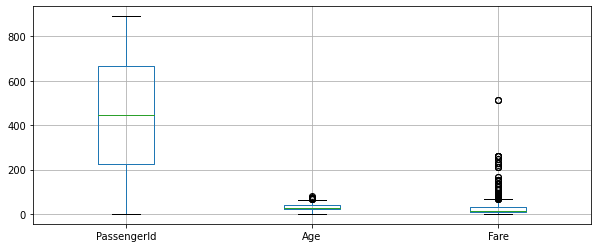

In [44]:
# outliers

data[continuous].boxplot(figsize=(10,4))

<AxesSubplot:>

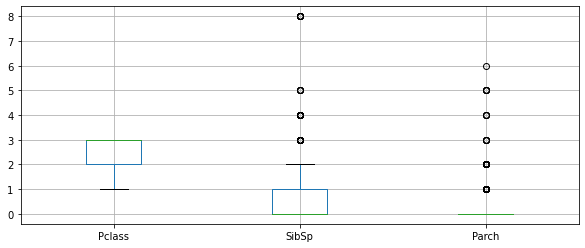

In [45]:
# outliers in discrete
data[discrete].boxplot(figsize=(10,4))

In [46]:
# Cabin
data['Cabin_num'] = data['Cabin'].str.extract('(\d+)') # captures numerical part
data['Cabin_num'] = data['Cabin_num'].astype('float')
data['Cabin_cat'] = data['Cabin'].str[0] # captures the first letter

# show dataframe
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_num,Cabin_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,85.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,123.0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN


Now that we extracted the numerical and categorical part, we can discard the mixed variable Cabin.

In [47]:
# drop original mixed

data.drop(['Cabin'], axis=1, inplace=True)

In [48]:
# cardinality high as number of records in dataset

data.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True)

In [49]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  # predictors
    data['Survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((801, 9), (90, 9))

### Missing data imputation

In [50]:
# numerical

X_train.select_dtypes(exclude='O').isnull().mean()

Pclass       0.000000
Age          0.197253
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin_num    0.781523
dtype: float64

In [51]:
# categorical

X_train.select_dtypes(include='O').isnull().mean()

Sex          0.000000
Embarked     0.002497
Cabin_cat    0.776529
dtype: float64

In [52]:
titanic_pipe = Pipeline([

    # missing data imputation  
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['Age', 'Fare', 'Cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['Embarked', 'Cabin_cat'])),

    # categorical encoding  
    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                                    n_categories=6,
                                    variables=['Cabin_cat'])),
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                                  variables=['Cabin_cat', 'Sex', 'Embarked'])),

    # Gradient Boosted machine
    ('gbm', GradientBoostingClassifier(random_state=0))
])

### Set up the Grid ad the cross-validation strategy

In [53]:
# now we create the grid with all the parameters that we would like to test

param_grid = {
    # try different feature engineering parameters
    'imputer_num__arbitrary_number': [-1, 99],
    'encoder_rare_label__tol': [0.1, 0.2],
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],
    
    # try different gradient boosted tree model paramenters
    'gbm__max_depth': [None, 1, 3],
}


# now we set up the grid search with cross-validation
grid_search = GridSearchCV(titanic_pipe, param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc')

# cv=5 is the cross-validation steps
# no_jobs =-1 indicates to use all available cpus
# scoring='roc-auc' indicates to evaluate the model performance with the roc-auc

In [54]:
# and now we train over all the possible combinations of the parameters above
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  category=UserWarning


best roc-auc from grid search: 0.999


In [55]:
grid_search.best_params_

{'categorical_encoder__encoding_method': 'ordered',
 'encoder_rare_label__tol': 0.1,
 'gbm__max_depth': None,
 'imputer_num__arbitrary_number': -1}

In [56]:
# and find the best fit parameters like this
grid_search.best_params_

{'categorical_encoder__encoding_method': 'ordered',
 'encoder_rare_label__tol': 0.1,
 'gbm__max_depth': None,
 'imputer_num__arbitrary_number': -1}

In [57]:
# here we can see all the combinations evaluated during the gridsearch
grid_search.cv_results_['params']

[{'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': None,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': None,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 1,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 1,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 3,
  'imputer_num__arbitrary_number': -1},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.1,
  'gbm__max_depth': 3,
  'imputer_num__arbitrary_number': 99},
 {'categorical_encoder__encoding_method': 'ordered',
  'encoder_rare_label__tol': 0.2,
  'gbm_

In [59]:
# and finally let's check the performance over the test set
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best linear regression from grid search: 0.752


In [60]:
new_data = pd.read_csv('test.csv')

new_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [61]:
# Cabin
new_data['Cabin_num'] = new_data['Cabin'].str.extract('(\d+)') # captures numerical part
new_data['Cabin_num'] = new_data['Cabin_num'].astype('float')
new_data['Cabin_cat'] = new_data['Cabin'].str[0] # captures the first letter

# show dataframe
new_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_num,Cabin_cat
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN,NaN


In [62]:
# drop original mixed

new_data.drop(['Cabin'], axis=1, inplace=True)

In [63]:
PassengerId = new_data['PassengerId']

In [64]:
new_data.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True)

In [66]:
new_data_preds = grid_search.predict_proba(new_data)[:,1]

In [67]:
t_pred = np.where(new_data_preds > 0.5, 1, 0)

In [68]:
Test_Sub = pd.DataFrame({'PassengerId': PassengerId, 'Survived':t_pred })
Test_Sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0


In [69]:
Test_Sub.to_csv("GBM_Submission_Cv.csv", index = False)